In [1]:
## imports ##

import sys
sys.path.append("../PythonScripts")
from ML_utils import LogTransformer, DropFeatures, addAdditionalFeatures, collapseFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn import svm, decomposition, tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.model_selection import learning_curve, GridSearchCV, cross_val_score, validation_curve
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import warnings
from sklearn.feature_selection import RFECV, SelectKBest, chi2, SelectFromModel, RFE
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import synapseclient as sc
%matplotlib inline

warnings.simplefilter("ignore")
sns.set_style("dark")
np.random.seed(100)

C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Contents:

- Gait data being used is based on the PDKit mPowerV1 data, collapsed by each healthCode ids
- Features chosen are based on a feature_engineering.ipnb
- For this ML Analysis, we will split the training-test set by 20%
- Parameters will be searched through grid search (GridSearchCV) and the score is assessed using Stratified 10-Fold Validation 
- Models being used: Logistic Regression, Xtreme Gradient Boost, Sklearn Gradient Boost and Random Forests
- Feature elimination will be done on several model using recursive feature elimination CV (Sklearn RFECV package)
- Learning Curves of each model (Work in progress)
- Best model will be dump into .pkl file (Work in progress)

## Helper Functions

In [130]:
def preprocess(X, feature_engineered):
    X = X.copy()
    
    if feature_engineered == False:
        X = collapseFeatures(aggregation_type = "max").transform(X)
        return X
    else:
        X = addAdditionalFeatures().transform(X)
        X = collapseFeatures(aggregation_type = "max").transform(X)
        X = LogTransformer(variables = [feat for feat in X.columns if ("frequency_of_peaks" in feat)]).transform(X)
        X = DropFeatures(variables_to_drop = [feat for feat in X.columns if ("stride_regularity" in feat)]).transform(X)
        X = DropFeatures(variables_to_drop = ["MAX_x.freeze_occurences", 
                                              "MAX_y.freeze_occurences", 
                                              "MAX_z.freeze_occurences",
                                              "MAX_AA.freeze_occurences",
                                              "MAX_x.no_of_steps", 
                                              "MAX_y.no_of_steps", 
                                              "MAX_z.no_of_steps",
                                              "MAX_FC.no_of_steps",
                                              "MAX_AA.no_of_steps",
                                              "MAX_x.frequency_of_peaks", 
                                              "MAX_y.frequency_of_peaks", 
                                              "MAX_z.frequency_of_peaks",
                                              "MAX_AA.frequency_of_peaks",
                                              "duration"]).transform(X)
        return X

def logreg_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(ExtraTreesClassifier(n_estimators = 100,
                                                                   random_state  = 100))),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state = 100))
        ])
    param = {}
    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV


def xgb_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(ExtraTreesClassifier(n_estimators = 100,
                                                            random_state  = 100))),
        ('classifier', XGBClassifier(seed = 100))
        ])
    param = {}
    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV
    

def gradientboost_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(estimator = ExtraTreesClassifier(n_estimators = 100,
                                                                              random_state  = 100))),
        ('classifier', GradientBoostingClassifier(random_state = 100))
        ])
    param = {}
    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV

def randomforest_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(estimator = ExtraTreesClassifier(n_estimators = 100,
                                                                              random_state = 100))),
        ('classifier', RandomForestClassifier(random_state = 100))
    ])
    param = {}
    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV


def printPerformance(model, X_test, y_test):
    print("Mean AUC score on K-folds: {}".format(model.best_score_))
    print("Parameter Used: {}".format(model.best_params_))
    y_true, y_pred = y_test, model.predict(X_test)
    print("ROC-AUC on Test-Set: {}".format(metrics.roc_auc_score(y_true, y_pred)))
    print("log-loss: {}".format(metrics.log_loss(y_true, y_pred)))
    print("Precision: {}".format(metrics.precision_score(y_true, y_pred)))
    print("Recall: {}".format(metrics.recall_score(y_true, y_pred)))
    print("F1-Score: {}".format(metrics.f1_score(y_true, y_pred)))

## Get Baseline Model and Feature Engineered Data

In [131]:
syn = sc.login()

Welcome, aryton tediarjo!



In [132]:
## Baseline ## 
entity = syn.get("syn21046180")
data   = pd.read_csv(entity["path"], index_col = 0)

In [133]:
feature_columns = [feat for feat in data.columns if ("." in feat) 
                   or ("duration" in feat) or ("healthCode" in feat)]
demographic_columns = [feat for feat in data.columns if "." not in feat]

In [134]:
## Baseline model without collapsed features ##
walking_X_train, walking_X_test, walking_y_train, walking_y_test = \
            train_test_split(data[feature_columns], 
                             data["PD"], test_size=0.25, random_state = 100)

## Run Model on Walking Data

In [135]:
def run_some_models(data, is_preprocess, is_feature_engineered):
    if is_preprocess == True:
        data = preprocess(data, is_feature_engineered)
        
    ## list of feature columns ## 
    feature_columns = [feat for feat in data.columns if ("." in feat)]
    ## Baseline model without collapsed features ##
    X_train, X_test, y_train, y_test = \
            train_test_split(data[feature_columns], 
                             data["PD"], test_size=0.25, random_state = 100)
    
    print("features used: {}".format(X_train.columns))
    
    ## run preliminary models ##
    lr_walking_model = logreg_fit(X_train, 
                                  y_train)
    rf_walking_model = randomforest_fit(X_train, 
                                        y_train)
    gb_walking_model = gradientboost_fit(X_train, 
                                         y_train)
    xgb_walking_model = xgb_fit(X_train, 
                                y_train)
    print("\n### Gradient Boosting Walking ###")
    printPerformance(gb_walking_model, X_test, y_test)
    print("\n### XTreme Gradient Boosting Walking ###")
    printPerformance(xgb_walking_model, X_test, y_test)
    print("\n### Random Forest Walking ###")
    printPerformance(rf_walking_model, X_test, y_test)
    print("\n### Logistic Regression Walking ###")
    printPerformance(lr_walking_model, X_test, y_test)

In [136]:
## model on max collapsed features ##
run_some_models(data, is_preprocess = True, is_feature_engineered = False)

features used: Index(['MAX_x.no_of_steps', 'MAX_x.gait_step_regularity',
       'MAX_x.gait_stride_regularity', 'MAX_x.gait_symmetry',
       'MAX_x.frequency_of_peaks', 'MAX_x.max_freeze_index',
       'MAX_x.freeze_occurences', 'MAX_x.speed_of_gait', 'MAX_y.no_of_steps',
       'MAX_y.gait_step_regularity', 'MAX_y.gait_stride_regularity',
       'MAX_y.gait_symmetry', 'MAX_y.frequency_of_peaks',
       'MAX_y.max_freeze_index', 'MAX_y.freeze_occurences',
       'MAX_y.speed_of_gait', 'MAX_z.no_of_steps',
       'MAX_z.gait_step_regularity', 'MAX_z.gait_stride_regularity',
       'MAX_z.gait_symmetry', 'MAX_z.frequency_of_peaks',
       'MAX_z.max_freeze_index', 'MAX_z.freeze_occurences',
       'MAX_z.speed_of_gait', 'MAX_AA.no_of_steps',
       'MAX_AA.gait_step_regularity', 'MAX_AA.gait_stride_regularity',
       'MAX_AA.gait_symmetry', 'MAX_AA.frequency_of_peaks',
       'MAX_AA.max_freeze_index', 'MAX_AA.freeze_occurences',
       'MAX_AA.speed_of_gait'],
      dtype='object')

#

In [137]:
## model on max collapsed features ##
run_some_models(data, is_preprocess = True, is_feature_engineered = True)

features used: Index(['MAX_x.gait_step_regularity', 'MAX_x.gait_symmetry',
       'MAX_x.max_freeze_index', 'MAX_x.speed_of_gait',
       'MAX_y.gait_step_regularity', 'MAX_y.gait_symmetry',
       'MAX_y.max_freeze_index', 'MAX_y.speed_of_gait',
       'MAX_z.gait_step_regularity', 'MAX_z.gait_symmetry',
       'MAX_z.max_freeze_index', 'MAX_z.speed_of_gait',
       'MAX_AA.gait_step_regularity', 'MAX_AA.gait_symmetry',
       'MAX_AA.max_freeze_index', 'MAX_AA.speed_of_gait',
       'MAX_FC.speed_of_gait', 'MAX_FC.no_of_steps_per_sec',
       'MAX_x.freeze_occurences_per_sec', 'MAX_y.freeze_occurences_per_sec',
       'MAX_z.freeze_occurences_per_sec', 'MAX_AA.freeze_occurences_per_sec',
       'MAX_x.frequency_of_peaks_log', 'MAX_y.frequency_of_peaks_log',
       'MAX_z.frequency_of_peaks_log', 'MAX_AA.frequency_of_peaks_log'],
      dtype='object')

### Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.5859374999999999
Parameter Used: {}
ROC-AUC on Test-Set: 0.622377622377

## Results

In [108]:
print(metrics.classification_report(gb_walking_model.predict(walking_X_test), 
                                    walking_y_test))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        26
           1       0.68      0.68      0.68        22

    accuracy                           0.71        48
   macro avg       0.71      0.71      0.71        48
weighted avg       0.71      0.71      0.71        48



In [60]:
pd.crosstab(gb_walking_model.best_estimator_.predict(walking_X_test), 
            walking_y_test, 
            rownames = ["Actual"], 
            colnames = ["Predicted"])

Predicted,0,1
Actual,,
0,19,7
1,7,15


In [61]:
print(metrics.classification_report(rf_walking_model.predict(walking_X_test), 
                                    walking_y_test))

              precision    recall  f1-score   support

           0       0.77      0.65      0.70        31
           1       0.50      0.65      0.56        17

    accuracy                           0.65        48
   macro avg       0.63      0.65      0.63        48
weighted avg       0.67      0.65      0.65        48



In [62]:
pd.crosstab(rf_walking_model.best_estimator_.predict(walking_X_test), 
            walking_y_test, 
            rownames = ["Actual"], 
            colnames = ["Predicted"])

Predicted,0,1
Actual,,
0,20,11
1,6,11


In [63]:
print(metrics.classification_report(xgb_walking_model.predict(walking_X_test), 
                                    walking_y_test))

              precision    recall  f1-score   support

           0       0.85      0.69      0.76        32
           1       0.55      0.75      0.63        16

    accuracy                           0.71        48
   macro avg       0.70      0.72      0.70        48
weighted avg       0.75      0.71      0.72        48



In [64]:
pd.crosstab(xgb_walking_model.best_estimator_.predict(walking_X_test), 
            walking_y_test, 
            rownames = ["Actual"], 
            colnames = ["Predicted"])

Predicted,0,1
Actual,,
0,22,10
1,4,12


In [65]:
## Model Feature Importances by Gini Index
print("### RF Feature Importances ####")

pd.Series(data = rf_walking_model.best_estimator_["classifier"].feature_importances_, 
          index = walking_X_train.columns[rf_walking_model.best_estimator_["feature_selection"].get_support()]).sort_values(ascending = False)

### RF Feature Importances ####


MAX_x.max_freeze_index              0.174516
MAX_z.gait_symmetry                 0.141352
MAX_AA.gait_symmetry                0.108085
MAX_y.log_frequency_of_peaks        0.098892
MAX_AA.freeze_occurences_per_sec    0.093319
MAX_z.freeze_occurences_per_sec     0.085955
MAX_z.max_freeze_index              0.075531
MAX_x.gait_symmetry                 0.074412
MAX_y.max_freeze_index              0.067576
MAX_x.freeze_occurences_per_sec     0.045399
MAX_fc.no_of_steps_per_sec          0.034964
dtype: float64

In [66]:
## Model Feature Importances
print("### GB Feature Importances ####")


pd.Series(data = gb_walking_model.best_estimator_["classifier"].feature_importances_, 
          index = walking_X_train.columns[gb_walking_model.best_estimator_["feature_selection"].get_support()]).sort_values(ascending = False)

### GB Feature Importances ####


MAX_x.max_freeze_index              0.190537
MAX_x.gait_symmetry                 0.121187
MAX_z.gait_symmetry                 0.119094
MAX_x.freeze_occurences_per_sec     0.110906
MAX_AA.freeze_occurences_per_sec    0.106599
MAX_AA.gait_symmetry                0.078841
MAX_fc.no_of_steps_per_sec          0.077961
MAX_z.freeze_occurences_per_sec     0.061659
MAX_z.max_freeze_index              0.052750
MAX_y.max_freeze_index              0.045077
MAX_y.log_frequency_of_peaks        0.035390
dtype: float64

# Learning Curves

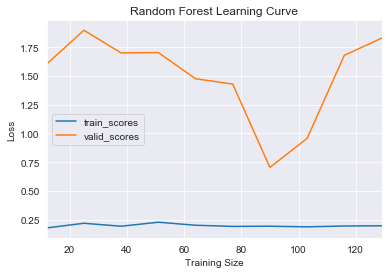

In [68]:
train_sizes, train_scores, valid_scores = learning_curve(rf_walking_model.best_estimator_, 
                                                         walking_X_train, walking_y_train, 
                                                         scoring = "neg_log_loss", 
                                                         cv = 10, random_state = 100, 
                                                         train_sizes = np.linspace(0.1, 1, 10))
pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1) * -1, 
                     "valid_scores": np.mean(valid_scores, axis = 1) * -1}, index = train_sizes).plot()
plt.ylabel("Loss")
plt.title("Random Forest Learning Curve")
plt.xlabel("Training Size")
plt.grid()

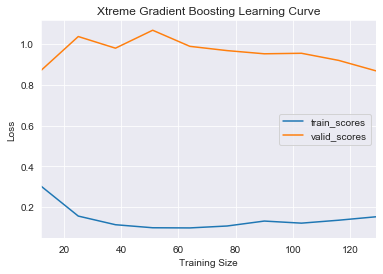

In [69]:
train_sizes, train_scores, valid_scores = learning_curve(xgb_walking_model.best_estimator_, 
                                                         walking_X_train, walking_y_train, 
                                                         scoring = "neg_log_loss", 
                                                         cv = 10, 
                                                         random_state = 100, 
                                                         train_sizes = np.linspace(0.1, 1, 10))
pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1) * -1, 
                     "valid_scores": np.mean(valid_scores, axis = 1) * -1}, index = train_sizes).plot()
plt.ylabel("Loss")
plt.title("Xtreme Gradient Boosting Learning Curve")
plt.xlabel("Training Size")
plt.grid()

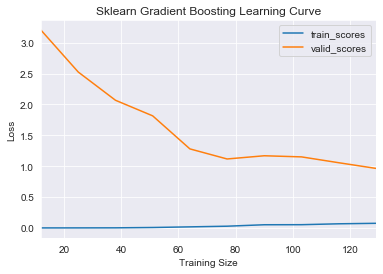

In [70]:
train_sizes, train_scores, valid_scores = learning_curve(gb_walking_model.best_estimator_, 
                                                         walking_X_train, walking_y_train, 
                                                         scoring = "neg_log_loss", 
                                                         cv = 10, 
                                                         random_state = 100, 
                                                         train_sizes = np.linspace(0.1, 1, 10))
pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1) * -1, 
                     "valid_scores": np.mean(valid_scores, axis = 1) * -1}, index = train_sizes).plot()
plt.ylabel("Loss")
plt.title("Sklearn Gradient Boosting Learning Curve")
plt.xlabel("Training Size")
plt.grid()

# Balance Data

In [30]:
balance_train = pd.read_csv("../Data/BALANCE_TRAINING_DATA.csv", index_col=0).reset_index(drop = True)
balance_X_train, balance_X_test, balance_y_train, balance_y_test = \
train_test_split(balance_train.drop(["PD"],axis = 1), balance_train["PD"], test_size=0.20, random_state = 100)

In [31]:
lr_balance_model = logreg_fit(balance_X_train, balance_y_train)
rf_balance_model = randomforest_fit(balance_X_train, balance_y_train)
gb_balance_model = gradientboost_fit(balance_X_train, balance_y_train)
xgb_balance_model = xgb_fit(balance_X_train, balance_y_train)


print("\n### Gradient Boosting Walking ###")
printPerformance(gb_balance_model, balance_X_test, balance_y_test)
print("\n### XTreme Gradient Boosting Walking ###")
printPerformance(xgb_balance_model, balance_X_test, balance_y_test)
print("\n### Random Forest Walking ###")
printPerformance(rf_balance_model, balance_X_test, balance_y_test)
print("\n### Logistic Regression Walking ###")
printPerformance(lr_balance_model, balance_X_test, balance_y_test)


### Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.7145191409897292
Parameter Used: {'classifier__learning_rate': 0.001, 'classifier__loss': 'deviance', 'classifier__max_depth': 2, 'classifier__n_estimators': 100}
ROC-AUC on Test-Set: 0.46825396825396826
log-loss: 19.48382237529844
Precision: 0.4444444444444444
Recall: 0.8888888888888888
F1-Score: 0.5925925925925926

### XTreme Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.6674836601307189
Parameter Used: {'classifier__gamma': 1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8, 'classifier__tree_method': 'hist'}
ROC-AUC on Test-Set: 0.46825396825396826
log-loss: 18.59806920665941
Precision: 0.43478260869565216
Recall: 0.5555555555555556
F1-Score: 0.4878048780487805

### Random Forest Walking ###
Mean AUC score on K-folds: 0.6847572362278244
Parameter Used: {'classifier__criterion': 'entropy', 'classifier__max_depth': 2, 'classifier__m

# Combining Features in Balance and Walking

In [113]:
from sklearn.feature_selection import SelectKBest, chi2

In [135]:
train = pd.concat([balance_train.drop("PD", axis = 1), walking_train], axis = 1)
train = train.groupby(train.columns, axis=1).mean().dropna()
combined_X_train, combined_X_test, combined_y_train, combined_y_test = \
train_test_split(train.drop(["PD"], axis = 1), train["PD"], test_size=0.20, random_state = 100)
selector = SelectKBest(chi2, k=15).fit(combined_X_train, combined_y_train)
pd.Series(data = selector.scores_, index = combined_X_train.columns).sort_values(ascending = False).head(15)

max_userAccel_y.frequency_of_peaks     3.442899e+08
max_userAccel_x.frequency_of_peaks     1.370186e+07
max_userAccel_AA.frequency_of_peaks    8.345348e+05
max_userAccel_z.frequency_of_peaks     4.602456e+04
max_userAccel_x.max_freeze_index       1.208810e+03
max_userAccel_z.max_freeze_index       8.897928e+02
max_userAccel_y.max_freeze_index       3.391854e+02
max_userAccel_x.freeze_occurences      4.986737e+01
max_userAccel_z.freeze_occurences      3.421301e+01
max_userAccel_y.freeze_occurences      1.917437e+01
max_userAccel_AA.freeze_occurences     1.778391e+01
max_userAccel_AA.max_freeze_index      1.230553e+01
max_userAccel_x.no_of_steps            2.433806e+00
max_userAccel_y.no_of_steps            5.537818e-01
max_userAccel_z.no_of_steps            3.679252e-01
dtype: float64

In [136]:
lr_balance_model = logreg_fit(combined_X_train, combined_y_train)
rf_balance_model = randomforest_fit(combined_X_train, combined_y_train)
gb_balance_model = gradientboost_fit(combined_X_train, combined_y_train)
xgb_balance_model = xgb_fit(combined_X_train, combined_y_train)


print("\n### Gradient Boosting Walking ###")
printPerformance(gb_balance_model, combined_X_test, combined_y_test)
print("\n### XTreme Gradient Boosting Walking ###")
printPerformance(xgb_balance_model, combined_X_test, combined_y_test)
print("\n### Random Forest Walking ###")
printPerformance(rf_balance_model, combined_X_test, combined_y_test)
print("\n### Logistic Regression Walking ###")
printPerformance(lr_balance_model, combined_X_test, combined_y_test)


### Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.7072510822510822
Parameter Used: {'classifier__learning_rate': 0.1, 'classifier__loss': 'exponential', 'classifier__max_depth': 6, 'classifier__n_estimators': 100}
ROC-AUC on Test-Set: 0.48351648351648346
log-loss: 18.285516772869254
Precision: 0.3684210526315789
Recall: 0.5384615384615384
F1-Score: 0.4375

### XTreme Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.6821789321789321
Parameter Used: {'classifier__gamma': 1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8, 'classifier__tree_method': 'auto'}
ROC-AUC on Test-Set: 0.5073260073260073
log-loss: 17.269646890741583
Precision: 0.3888888888888889
Recall: 0.5384615384615384
F1-Score: 0.45161290322580644

### Random Forest Walking ###
Mean AUC score on K-folds: 0.7160894660894661
Parameter Used: {'classifier__criterion': 'entropy', 'classifier__max_depth': 9, 'classifier__max_feature

# Saving Serialized Results

The walking models will be the only one taken for further assessment towards V2 data due to its decent performance of ROC-AUC > 0.6. Model will be refitted to the test sets.

In [55]:
import pickle
from sklearn.externals import joblib 

### Refit Model to Tests Sets

In [56]:
refitted_lr = lr_walking_model.best_estimator_.fit(walking_X_test, walking_y_test)
refitted_gb = gb_walking_model.best_estimator_.fit(walking_X_test, walking_y_test)
refitted_xgb = xgb_walking_model.best_estimator_.fit(walking_X_test, walking_y_test)
refitted_rf = rf_walking_model.best_estimator_.fit(walking_X_test, walking_y_test)

In [57]:
models = ["refitted_lr", "refitted_gb", "refitted_xgb", "refitted_rf"]


for model in models:
    joblib.dump(globals()[model], '../Models/{}.pkl'.format(model))